In [1]:
from interactome_funcs import *

In [2]:
# filtered pdb structures for uniprot entries
pdb = pd.read_csv("processed_data/uniprot/proteome_have_pdb_begin_end_missing_consec_greater_30pdb.csv")
# filtered homology modeling datasets
modbase = pd.read_csv('processed_data/modbase/modbase_30aa_hq.tsv', sep='\t')
modbase = modbase.rename(columns={'UniprotID': 'Entry'})
swissmodel = pd.read_csv('processed_data/swissmodel/swissmodel_30aa_hq.tsv', sep='\t')
swissmodel = swissmodel.rename(columns={'UniProtKB_ac': 'Entry'})

/home/zeynep/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# filtered alphafold structures
af_85 = pd.read_excel('processed_data/alphafold/all_af_acc_85.xlsx')
af_70 = pd.read_excel('processed_data/alphafold/all_af_acc_70.xlsx')
af_50 = pd.read_excel('processed_data/alphafold/all_af_acc_50.xlsx')

def get_acc(af_raw):
    af = af_raw[af_raw['Situation'] == 'Yes']
    return af

af_85, af_70, af_50 = get_acc(af_85), get_acc(af_70), get_acc(af_50)

In [4]:
models = modbase.merge(swissmodel, on='Entry', how='outer').merge(af_85, on='Entry', how='outer')

In [6]:
# interactome databases
huri = pd.read_excel('processed_data/interactomes/huri/huri_final.xlsx')
string = pd.read_excel('processed_data/interactomes/string/string_high_conf_final.xlsx')
bioplex = pd.read_excel('processed_data/interactomes/bioplex/bioplex_293t_final.xlsx')
hippie = pd.read_excel('processed_data/interactomes/hippie/hippie_binary_hq_final.xlsx')
apid = pd.read_excel('processed_data/interactomes/apid/apid_final.xlsx')
pickle = pd.read_excel('processed_data/interactomes/pickle/pickle_final.xlsx')
biogrid = pd.read_csv('processed_data/interactomes/biogrid/biogrid_final.tsv', sep='\t')
iid = pd.read_csv('processed_data/interactomes/iid/iid_exp_final.tsv', sep='\t')

In [10]:
def classify_interactions(interactome_df, df_name, str_dtb, model_dtbs, ids=["protein1_uniprot", "protein2_uniprot"]):
    interactions = interactome_df[ids].to_numpy()
    stats = [df_name, 0, 0, 0, 0] # database name, both experimental, only one experimental, both models, nothing
    str_dtb_ids = str_dtb['Entry'].unique()
    model_dtbs_ids = model_dtbs['Entry'].unique()
    
    for pair in interactions:
        p1, p2 = pair[0], pair[1]
        if p1 in str_dtb_ids:
            if p2 in str_dtb_ids:
                stats[1] += 1
            elif p2 in model_dtbs_ids:
                stats[2] += 1
            else:
                stats[4] += 1
        elif p1 in model_dtbs_ids:
            if p2 in str_dtb_ids:
                stats[2] += 1
            elif p2 in model_dtbs_ids:
                stats[3] += 1
            else:
                stats[4] += 1
        else:
            stats[4] += 1
                
    return stats

In [ ]:
huri_stats = classify_interactions(huri, "HuRI", pdb, models)
string_stats = classify_interactions(string, "STRING", pdb, models)
bioplex_stats = classify_interactions(bioplex, "BioPlex", pdb, models)
hippie_stats = classify_interactions(hippie, "HIPPIE", pdb, models)

In [9]:
apid_stats = classify_interactions(apid, "APID", pdb, models, ids=['UniprotID_A', 'UniprotID_B'])
pickle_stats = classify_interactions(pickle, "PICKLE", pdb, models, ids=['InteractorA', 'InteractorB'])
biogrid_stats = classify_interactions(biogrid, "BioGRID", pdb, models, ids=['SWISS-PROT Accessions Interactor A', 'SWISS-PROT Accessions Interactor B'])
iid_stats = classify_interactions(iid, "IID", pdb, models, ids=['uniprot1', 'uniprot2'])

In [10]:
all_stats = [huri_stats, bioplex_stats, string_stats, hippie_stats, apid_stats, pickle_stats, biogrid_stats, iid_stats]
all_stats = pd.DataFrame(data = dfs, columns= ["Database", "exp-exp", "exp-model", "model-model", "rest"])
all_stats['total'] = all_stats.apply(lambda x: x['exp-exp'] + x['exp-model'] + x['model-model'] + x['rest'], axis=1)
all_stats.to_excel("processed_data/interactomes/interactions_by_databases_final.xlsx", index=False)

In [2]:
all_stats = pd.read_excel("processed_data/interactomes/interactions_by_databases_final.xlsx")

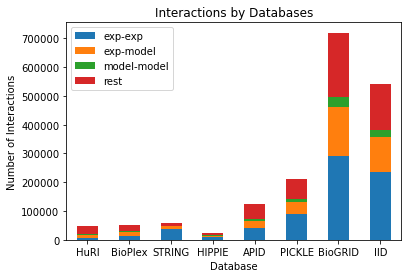

In [3]:
from matplotlib import pyplot as plt
ax = all_stats.plot(x="Database", y=["exp-exp", "exp-model", "model-model", "rest"], kind="bar", rot=0, stacked=True)
#_ = ax.legend(bbox_to_anchor=(0.68, 1), loc='upper left')
_ = ax.legend(bbox_to_anchor=(0, 1), loc='upper left')
ax.set_title('Interactions by Databases')
ax.set_ylabel('Number of Interactions')
plt.savefig('figures/interactome/interactions_by_databases_final.png', dpi=600)

In [ ]:
from matplotlib import pyplot as plt
dfs4 = [huri_stats, bioplex_stats, string_stats, hippie_stats]
all_stats4 = pd.DataFrame(data = dfs4, columns= ["Database", "exp-exp", "exp-model", "model-model", "rest"])
ax = all_stats4.plot(x="Database", y=["exp-exp", "exp-model", "model-model", "rest"], kind="bar", rot=0, stacked=True)
_ = ax.legend(bbox_to_anchor=(0.68, 1), loc='upper left')
#_ = ax.legend(bbox_to_anchor=(0, 1), loc='upper left')
ax.set_title('Interactions by Databases')
ax.set_ylabel('Number of Interactions')
plt.savefig('figures/interactome/interactions_by_databases_4_final.png', dpi=600)

In [15]:
all_stats_pct['exp-exp (%)'] = all_stats_pct['exp-exp'].div(all_stats_pct['total']).map('{:.2%}'.format).replace('[\%,]', '', regex=True).astype(float)
all_stats_pct['exp-model (%)'] = all_stats_pct['exp-model'].div(all_stats_pct['total']).map('{:.2%}'.format).replace('[\%,]', '', regex=True).astype(float)
all_stats_pct['model-model (%)'] = all_stats_pct['model-model'].div(all_stats_pct['total']).map('{:.2%}'.format).replace('[\%,]', '', regex=True).astype(float)
all_stats_pct['rest (%)'] = all_stats_pct['rest'].div(all_stats_pct['total']).map('{:.2%}'.format).replace('[\%,]', '', regex=True).astype(float)
all_stats_pct.to_excel("processed_data/interactomes/interactions_by_databases_pct_final.xlsx", index=False)

In [4]:
all_stats_pct = pd.read_excel("processed_data/interactomes/interactions_by_databases_pct_final.xlsx")

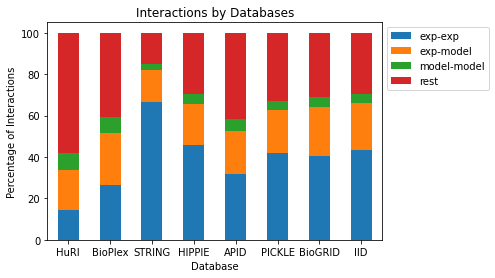

In [5]:
ax = all_stats_pct.plot(x="Database", y=["exp-exp (%)", "exp-model (%)", "model-model (%)", "rest (%)"], 
                    label=["exp-exp", "exp-model", "model-model", "rest"], 
                    kind="bar", rot=0, stacked=True)
_ = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_title('Interactions by Databases')
ax.set_ylabel('Percentage of Interactions')
plt.savefig('figures/interactome/interactions_by_databases_pct_final.png', dpi=600)

## Inset Plot

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

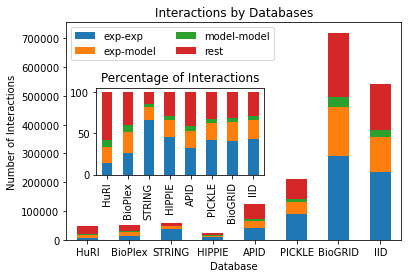

In [49]:
ax = all_stats.plot(x="Database", y=["exp-exp", "exp-model", "model-model", "rest"], kind="bar", rot=0, stacked=True)
_ = ax.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=2)
ax.set_title('Interactions by Databases')
ax.set_ylabel('Number of Interactions')

axins = inset_axes(ax,  "50%", "40%", loc="center left", borderpad=3)

all_stats_pct.plot(x="Database", y=["exp-exp (%)", "exp-model (%)", "model-model (%)", "rest (%)"], 
                    kind="bar", rot=90, stacked=True, ax=axins)
axins.set_title('Percentage of Interactions')
axins.set_xlabel(None)
axins.get_legend().remove()
plt.savefig('figures/interactome/inset_version.png', dpi=700, bbox_inches='tight')